In [1]:
import sys
sys.path.append('/Users/mahsazarei/Grantlab Brugada Dropbox/TerraMera/Gitlab/Mahsa/AA_APLID/Amino_Acid_manuscript/helper_functions')
from load_data import *
from utils import *
from models import *

# Step 1: Read AAM (spectra) and AA proportions (ground-truth)

In [2]:
root_dir = '/Users/mahsazarei/Grantlab Brugada Dropbox/TerraMera/Gitlab/Mahsa/AA_APLID/Amino_Acid_manuscript/Data/AAM_Data'
file_name_list = ['AAM_Data.csv', '50_50_quartz_calcite.csv']


In [3]:
df = pd.read_csv(os.path.join(root_dir, file_name_list[0]))
w = [c for c in df.columns if c[0] in np.array(range(10), dtype=str)]


In [4]:
mask_ex = [col.startswith('') for col in df['names']]
names_ex = df['names'].values
w_nm = np.array([float(idx) for idx in w])
w_cm = wavelength_to_wavenumber(w_nm, 784.815734863281)
specs_ex = df.loc[mask_ex, w].values

data_dir_y = '/Users/mahsazarei/Grantlab Brugada Dropbox/TerraMera/Gitlab/Mahsa/AA_APLID/Amino_Acid_manuscript/Data/AA_GroundTruth/AAM_proportions.xlsx'
df_gt, y_ex, y_names, namess= y_loader_by_path(data_dir_y)
y_expanded = [y_ex[df_gt.index==name] for name in names_ex]
y_ex = np.vstack(y_expanded)
print(specs_ex.shape, names_ex.shape, y_ex.shape)


(12956, 1024) (12956,) (12956, 6)


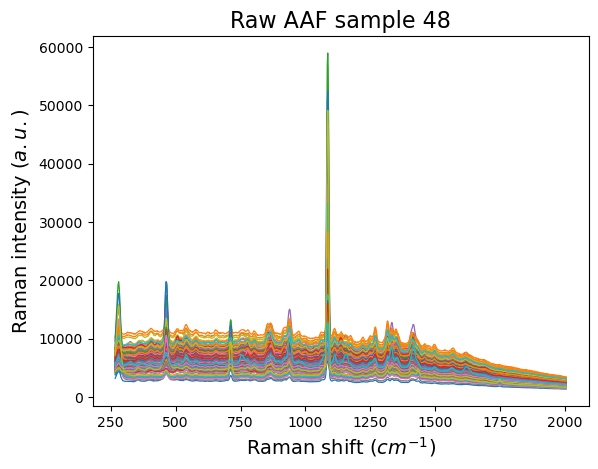

In [5]:
plot_specs(specs_ex[names_ex=='maa48r'], w_cm,  title='Raw AAF sample 48', data='Raman')

# Step 2: Preprocessing Table of Contents
- [0. Minerals peak removal test](#remove_minerals)
- [1. Background subtraction using Discrete Wavelet Transform (DWT) - one spectrum](#dwt_background)
- [1.1 Background subtraction using Discrete Wavelet Transform (DWT) - all spectra](#dwt_all_spectra)
- [2. SFR calculation](#sfr_calculation)
- [3. SNR calculation](#snr_calculation)
- [4. Z-score normalization](#z_score_normalization)
- [5. Averaging replicas of each sample](#averaging_replicas)

<a id="remove_minerals"></a>
## 0. Minerals peak removal test

specs_ex shape after mineral peak removal: (12956, 741)


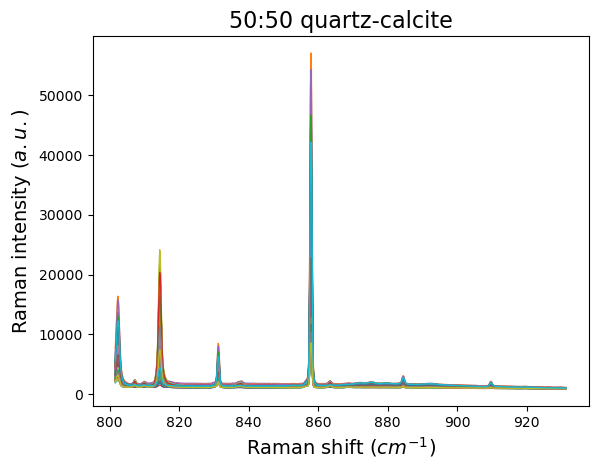

<Figure size 1500x500 with 0 Axes>

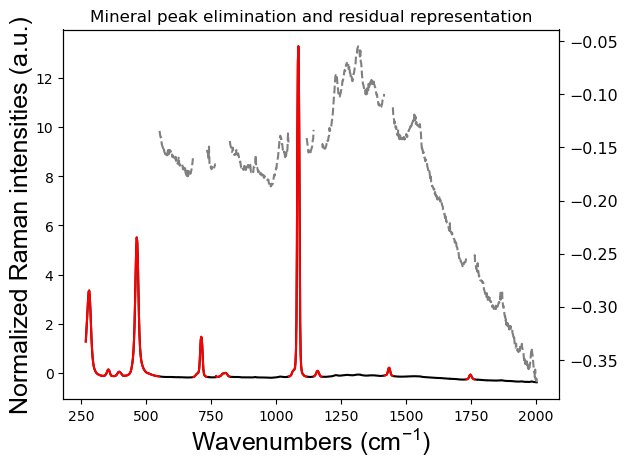

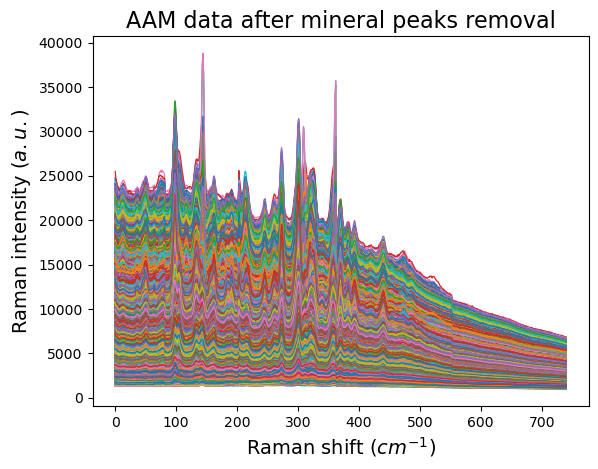

In [5]:
mineral_peaks_removal = False  # Change this to True or False based on your requirement

if mineral_peaks_removal:
    # 1. 50:50 mineral mixtures
    df_quartz_calcite = pd.read_csv(os.path.join(root_dir, file_name_list[1]), skiprows=45)
    columns = [c for c in df_quartz_calcite.columns if 'Raw' in c]
    quartz_calcite = df_quartz_calcite[columns].values
    quartz_calcite_ave = np.vstack([np.mean(s) for s in quartz_calcite])
    specss_m = norm_mean(np.vstack([np.mean(s) for s in quartz_calcite_ave]))
    plot_specs(quartz_calcite.T, w_nm, id_list=None, title="50:50 quartz-calcite", data='Raman')

    # 2. Mineral peak elimination representative
    plot_mineral_peak_elimination(specss_m, w_cm)

    # 3. Removing mineral peaks of all raw AAM spectra
    specs_ex_minerals_removed = mineral_peaks_removal_impute(specs_ex)
    print("specs_ex shape after mineral peak removal:", specs_ex_minerals_removed.shape)

    # 4. Plotting the raw AA spectra after mineral peaks removed
    plot_M_removed = False
    if plot_M_removed:
        plot_specs(specs_ex_minerals_removed, id_list=None, title="AAM data after mineral peaks removal", data='Raman')
        specs_ex = specs_ex_minerals_removed



<a id="dwt_background"></a>
## 1. Background subtraction using Discrete Wavelet Transform (DWT) - one spectrum

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


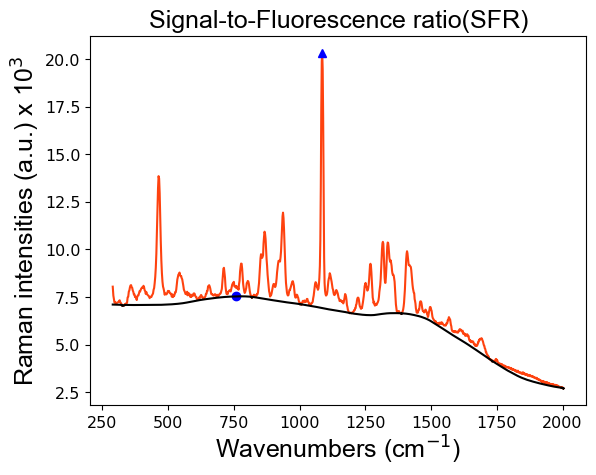

In [6]:
scale = 7           # scale of the DWT multilevel decomposition 
wavelet = 'sym5'    # mother wavelet
iterations = 100    # Bakcground removal iterations
spec = 1000
start = 10
plt.figsize=(15, 5)
tick_label_size = 11.43
name_size = 18
spectrum_bg_removed, bg_approx = dwt_iterative_bg_rm(specs_ex[spec, :][start:], wavelet, scale, iterations)
plt.plot(w_cm[start:], specs_ex[spec, :][start:]/1000, color='#FE420F')
plt.plot(w_cm[np.argmax(specs_ex[spec, :])], np.max(specs_ex[spec])/1000, '^', color='blue', label='Raman Maximum')
plt.plot(w_cm[np.argmax(bg_approx)], np.max(bg_approx)/1000, 'o', color='blue', label='Fluorescence Maximum')
plt.plot(w_cm[start:], bg_approx/1000, color='black')
plt.xlabel('Wavenumbers (cm$^{-1}$)', fontsize=name_size, font='Arial', labelpad=2)
plt.ylabel('Raman intensities (a.u.) x 10$^{3}$', fontsize=name_size, font='Arial', labelpad=2)
plt.title('Signal-to-Fluorescence ratio(SFR)', fontdict={'fontsize': name_size, 'fontname': 'Arial'})
plt.tick_params(axis='both', which='both', labelsize=tick_label_size)

<a id="dwt_all_spectra"></a>
### 1.1 Background subtraction using Discrete Wavelet Transform (DWT) - all spectra

In [7]:
background_removal = False
if background_removal:
    specs_bg_removed = np.zeros(specs_ex.shape)
    bg_approx = np.zeros(specs_ex.shape)
    for spectrum in range(specs_ex.shape[0]):
        specs_bg_removed[spectrum, :], bg_approx[spectrum, :] = dwt_iterative_bg_rm(specs_ex[spectrum, :], wavelet, scale, iterations)

    specs = specs_bg_removed 

<a id="sfr_calculation"></a>
## 2. SFR calculation

In [8]:
if background_removal:
    SFR = []
    for i in range(specs_bg_removed.shape[0]):
        SFR.append(np.divide(np.max(specs_bg_removed[i, :]), np.max(bg_approx[i, :])))
    SFR_mean = np.mean(np.array(SFR))
    print(SFR_mean)

<a id="snr_calculation"></a>
## 3. SNR calculation

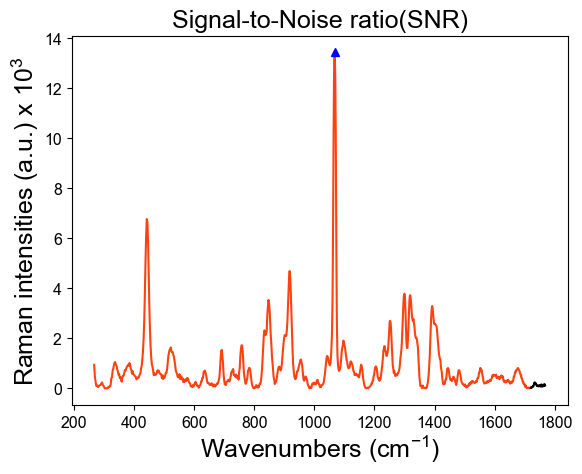

In [10]:
pivot1 = 805
pivot2 = 840
plt.figsize=(15, 5)
tick_label_size = 11.43
name_size = 18
plt.plot(w_cm[:pivot1], spectrum_bg_removed[ :pivot1]/1000, color='#FE420F')
plt.plot(w_cm[pivot1:pivot2:], spectrum_bg_removed[pivot1:pivot2:]/1000, color='black', label= 'Noise Region')
plt.plot(w_cm[np.argmax(spectrum_bg_removed)], np.max(spectrum_bg_removed)/1000, '^', color='blue', label= 'Maximum Raman')
plt.xlabel('Wavenumbers (cm$^\mathdefault{-1}$)', fontsize=name_size, font='Arial', labelpad=2)
plt.ylabel('Raman intensities (a.u.) x 10$^\mathdefault{3}$', fontsize=name_size, font='Arial', labelpad=2)
plt.xticks(fontname='Arial') 
plt.yticks(fontname='Arial')
plt.title('Signal-to-Noise ratio(SNR)', fontdict={'fontsize': name_size, 'fontname': 'Arial'})
plt.tick_params(axis='both', which='both', labelsize=tick_label_size) 

In [11]:
if background_removal:
    specs_norm = np.vstack([norm_mean(s) for s in specs_bg_removed])
    SNR = []
    for noisy_spec in specs_norm:
        SNR.append(np.divide(np.max(noisy_spec), np.std(noisy_spec[pivot1:pivot2])))
    SNR_mean = np.mean(np.array(SNR))
    SNR_std = np.std(np.array(SNR))
    print(SNR_mean)

<a id="z_score_normalization"></a>
## 4. Z-score normalization

In [13]:
specss = np.vstack([norm_mean(s) for s in specs_ex])

<a id="averaging_replicas"></a>
## 5. Averaging replicas of each sample

In [14]:
specss_ave = np.vstack([np.mean(specss[names_ex==name, :], axis=0) for name in np.unique(names_ex)])
y_ave = np.vstack([np.mean(y_ex[names_ex==name, :], axis=0) for name in np.unique(names_ex)])

print(specss_ave.shape, y_ave.shape)

(48, 1024) (48, 6)


# Step 3: Modeling Table of Contents

- 1. [Partial Least Squares Regression (PLSR) optimal number of components - PRESS](#PRESS) 
- 1.1 [Partial Least Squares Regression (PLSR) - Leave-one-out cross validation & K-fold cv](#plsr)
- 2. [Convolutional Neural Network (CNN) - Leave-one-out cross validation & learning curve](#cnn)
- 3. [PLSR vs CNN calibration figure](#plsrvscnn)

<a id="PRESS"></a>
## 1. Partial Least Squares Regression (PLSR) optimal number of components - PRESS
We achieved convergence at 7 components and thus 10 components should be chosen. Adding more components increases the complexity of the model. While both 7 and 10 components may produce similar R^2 and MSE values, the model with 10 components is inherently more complex. More complex models have a higher risk of overfitting, which means they might perform well on the training data but generalize poorly to new, unseen data.

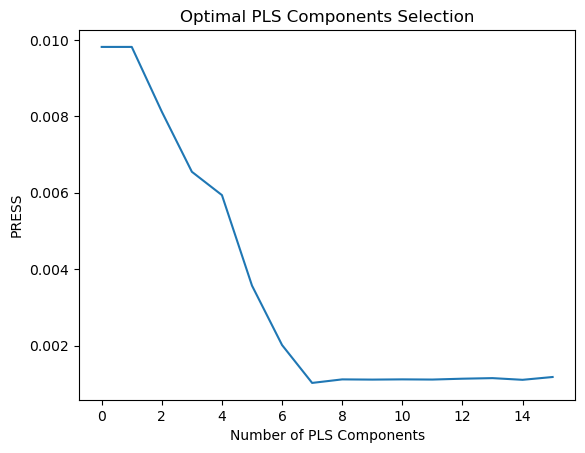

PLSR number of components with minimum MSE: 7


In [15]:
n_components_min_mse = select_optimal_pls_components(specss_ave, y_ave, max_components=15)
print("PLSR number of components with minimum MSE:", n_components_min_mse)

<a id="PRESS"></a>
## 1.1 Partial Least Squares Regression (PLSR) - Leave-one-out cross validation & K-fold cv

In [16]:
y_pred_cv_plsr = cross_val_predict(PLSRegression(n_components=9), specss_ave, y_ave, groups=np.unique(names_ex), cv=LeaveOneOut())
# y_pred_cv_plsr = cross_val_predict(PLSRegression(n_components=15), specss_m4, y_m4, cv=GroupKFold(n_splits=np.unique(names_ex).shape[0]))


r2:0.89, MSE:0.001088, MAE:0.024258
alanine
r2:0.89, MSE:0.001024, MAE:0.024268
asparagine
r2:0.90, MSE:0.000953, MAE:0.024330
aspartic acid
r2:0.80, MSE:0.001664, MAE:0.026363
glutamic acid
r2:0.90, MSE:0.001125, MAE:0.025140
histidine
r2:0.91, MSE:0.001159, MAE:0.025820
glucosamine
r2:0.91, MSE:0.000602, MAE:0.019629


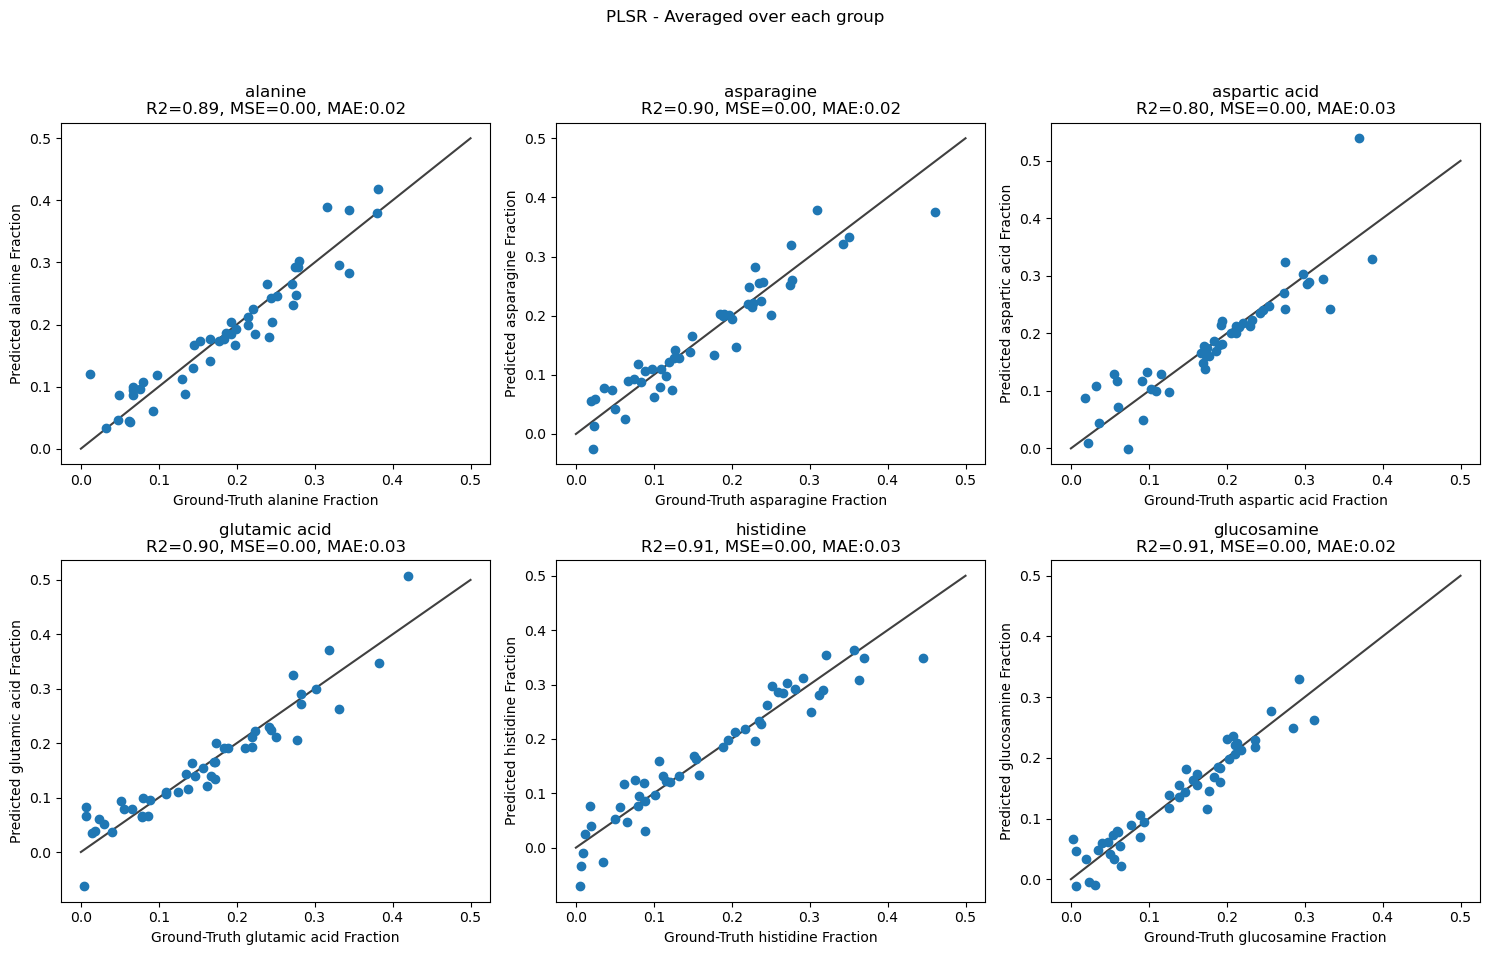

In [17]:
# For PLSR model results
plot_regression_results(y_ave, y_pred_cv_plsr, y_names, model_type='PLSR', title='PLSR Model Results')


<a id="cnn"></a>
## 2. Convolutional Neural Network (CNN) - Leave-one-out cross validation & learning curve

In [18]:
def cnn_6_ratios(cfg):
    model = models.Sequential()
    model.add(layers.Conv1D(8, 3, activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(16, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(32, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Dropout(0.2))    
    model.add(layers.Flatten())
    model.add(layers.Dense(64))
    model.add(layers.Dense(6))

    model.summary()
    if cfg['compile']:
        model.compile(optimizer=cfg['opt'], loss='mse', metrics=['mse'])
    return model

In [31]:
def cnn_AA_general(cfg, input_shape=(1024, 1), num_filters=(16, 32, 64), num_dense_filters=32):
    """
    General model for Raman data.
    Input: Model configurations, input_shape, num_filters, num_dense_filters
    Output: Model
    """
    model = models.Sequential()
    for num_filter in num_filters[:-1]:
        model.add(layers.Conv1D(num_filter, 3, activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(num_filters[-1], 3, activation='relu'))
#     model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_dense_filters))
    model.add(layers.Dense(6))
    
    model.summary()
    if cfg['compile']:
        model.compile(optimizer=cfg['opt'], loss='mse', metrics=['mse'])
    return model


In [32]:
from tensorflow.keras.optimizers import Adam

model_cfg = {
    'compile': True,
    'opt': Adam(learning_rate=0.001)
}

num_filters = (8, 16, 32, 64, 128) # Specify the number of filters for the convolutional layers
num_dense_filters = 128          # Specify the number of filters in the first dense layer

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

y_pred_cv_cnn_m4 = []
y_cv_cnn_m4 = []

for idx_train, idx_test in LeaveOneOut().split(specss_ave, y_ave, np.unique(names_ex)):
    model = cnn_AA_general(model_cfg, num_filters=num_filters, num_dense_filters=num_dense_filters)
    history = model.fit(np.expand_dims(specss_ave[idx_train, :], 2), y_ave[idx_train], epochs=50, batch_size=8, validation_data=(np.expand_dims(specss_ave[idx_test], 2), y_ave[idx_test]), callbacks=[es])
    y_pred_cv_cnn_m4.append(model.predict(np.expand_dims(specss_ave[idx_test], 2)))
    y_cv_cnn_m4.append(y_ave[idx_test])
    
y_pred_cv_cnn_m4 = np.vstack(y_pred_cv_cnn_m4)
y_cv_cnn_m4 = np.vstack(y_cv_cnn_m4)

# saved_predictios_path = '/Users/mahsazarei/Grantlab Brugada Dropbox/Mahsa Zarei/A_Mahsa_Benchmarking_Data/manuscript_figures/saved_predictions_CSVs'
# # Save y_pred_cv_cnn_m4 and y_cv_cnn_m4 to CSV
# np.savetxt(os.path.join(saved_predictios_path, 'y_pred_cv_cnn_m4.csv'), y_pred_cv_cnn_m4, delimiter=',')
# np.savetxt(os.path.join(saved_predictios_path, 'y_cv_cnn_m4.csv'), y_cv_cnn_m4, delimiter=',')


Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_720 (Conv1D)         (None, 1022, 8)           32        
                                                                 
 max_pooling1d_576 (MaxPooli  (None, 511, 8)           0         
 ng1D)                                                           
                                                                 
 conv1d_721 (Conv1D)         (None, 509, 16)           400       
                                                                 
 max_pooling1d_577 (MaxPooli  (None, 254, 16)          0         
 ng1D)                                                           
                                                                 
 conv1d_722 (Conv1D)         (None, 252, 32)           1568      
                                                                 
 max_pooling1d_578 (MaxPooli  (None, 126, 32)       

Epoch 1/50
6/6 [==============================] - 4s 500ms/step - loss: 0.0551 - mse: 0.0551 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 2/50
6/6 [==============================] - 0s 56ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 3/50
6/6 [==============================] - 0s 68ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 4/50
6/6 [==============================] - 1s 114ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 5/50
6/6 [==============================] - 0s 80ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 6/50
6/6 [==============================] - 0s 40ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 7/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0080 - mse: 0.0080 - v

Epoch 1/50
6/6 [==============================] - 4s 427ms/step - loss: 0.0833 - mse: 0.0833 - val_loss: 0.0562 - val_mse: 0.0562
Epoch 2/50
6/6 [==============================] - 1s 152ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 3/50
6/6 [==============================] - 0s 47ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 7/50
6/6 [==============================] - 0s 46ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 8/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0077 - mse: 0.0077 - v

Epoch 1/50
6/6 [==============================] - 4s 450ms/step - loss: 0.4904 - mse: 0.4904 - val_loss: 0.2631 - val_mse: 0.2631
Epoch 2/50
6/6 [==============================] - 0s 73ms/step - loss: 0.1185 - mse: 0.1185 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 3/50
6/6 [==============================] - 0s 49ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 5/50
6/6 [==============================] - 1s 158ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 7/50
6/6 [==============================] - 0s 83ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0084 - mse: 0.0084 - v

Epoch 1/50
6/6 [==============================] - 4s 358ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 2/50
6/6 [==============================] - 1s 130ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 3/50
6/6 [==============================] - 1s 96ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 5/50
6/6 [==============================] - 0s 50ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 6/50
6/6 [==============================] - 0s 91ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 7/50
6/6 [==============================] - 0s 52ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0037 - mse: 0.0037 - v

Epoch 1/50
6/6 [==============================] - 5s 359ms/step - loss: 0.3100 - mse: 0.3100 - val_loss: 0.1936 - val_mse: 0.1936
Epoch 2/50
6/6 [==============================] - 1s 103ms/step - loss: 0.0865 - mse: 0.0865 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 3/50
6/6 [==============================] - 1s 149ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 4/50
6/6 [==============================] - 1s 93ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 5/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 6/50
6/6 [==============================] - 0s 47ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 7/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 5.1257e-04 - val_mse: 5.1257e-04
Epoch 8/50
6/6 [==============================] - 0s 51ms/step - loss: 0.0050 - mse: 0

Epoch 1/50
6/6 [==============================] - 4s 457ms/step - loss: 0.3730 - mse: 0.3730 - val_loss: 0.2365 - val_mse: 0.2365
Epoch 2/50
6/6 [==============================] - 0s 78ms/step - loss: 0.0865 - mse: 0.0865 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 3/50
6/6 [==============================] - 0s 63ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 4/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 5/50
6/6 [==============================] - 0s 55ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 6/50
6/6 [==============================] - 0s 43ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0072 - mse: 0.0072 - va

Epoch 1/50
6/6 [==============================] - 4s 466ms/step - loss: 0.1650 - mse: 0.1650 - val_loss: 0.0616 - val_mse: 0.0616
Epoch 2/50
6/6 [==============================] - 0s 63ms/step - loss: 0.0450 - mse: 0.0450 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 3/50
6/6 [==============================] - 0s 56ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 4/50
6/6 [==============================] - 1s 105ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 5/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 6/50
6/6 [==============================] - 0s 71ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 7/50
6/6 [==============================] - 0s 70ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 8/50
6/6 [==============================] - 0s 88ms/step - loss: 0.0059 - mse: 0.0059 - v

Epoch 1/50
6/6 [==============================] - 3s 387ms/step - loss: 0.3704 - mse: 0.3704 - val_loss: 0.2493 - val_mse: 0.2493
Epoch 2/50
6/6 [==============================] - 1s 95ms/step - loss: 0.0891 - mse: 0.0891 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 3/50
6/6 [==============================] - 1s 176ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 4/50
6/6 [==============================] - 0s 58ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 5/50
6/6 [==============================] - 0s 40ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 6/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 7/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 8/50
6/6 [==============================] - 0s 70ms/step - loss: 0.0053 - mse: 0.0053 - v

Epoch 1/50
6/6 [==============================] - 4s 427ms/step - loss: 0.2911 - mse: 0.2911 - val_loss: 0.1207 - val_mse: 0.1207
Epoch 2/50
6/6 [==============================] - 1s 112ms/step - loss: 0.0608 - mse: 0.0608 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 3/50
6/6 [==============================] - 1s 100ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 4/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 5/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 6/50
6/6 [==============================] - 0s 76ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 8/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0063 - mse: 0.0063 - 

Epoch 1/50
6/6 [==============================] - 4s 473ms/step - loss: 0.0607 - mse: 0.0607 - val_loss: 0.0395 - val_mse: 0.0395
Epoch 2/50
6/6 [==============================] - 1s 156ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 3/50
6/6 [==============================] - 0s 69ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 4/50
6/6 [==============================] - 0s 54ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 5/50
6/6 [==============================] - 0s 54ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 7/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 8/50
6/6 [==============================] - 0s 51ms/step - loss: 0.0048 - mse: 0.0048 - v

Epoch 1/50
6/6 [==============================] - 3s 296ms/step - loss: 0.2449 - mse: 0.2449 - val_loss: 0.1245 - val_mse: 0.1245
Epoch 2/50
6/6 [==============================] - 1s 88ms/step - loss: 0.0647 - mse: 0.0647 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 3/50
6/6 [==============================] - 1s 51ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 4/50
6/6 [==============================] - 0s 55ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 5/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 6/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0065 - mse: 0.0065 - va

Epoch 1/50
6/6 [==============================] - 4s 472ms/step - loss: 0.0955 - mse: 0.0955 - val_loss: 0.0620 - val_mse: 0.0620
Epoch 2/50
6/6 [==============================] - 0s 68ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 3/50
6/6 [==============================] - 1s 107ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 4/50
6/6 [==============================] - 1s 53ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 5/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 7/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 8/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0064 - mse: 0.0064 - v

Epoch 1/50
6/6 [==============================] - 4s 481ms/step - loss: 0.2185 - mse: 0.2185 - val_loss: 0.1234 - val_mse: 0.1234
Epoch 2/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0615 - mse: 0.0615 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 3/50
6/6 [==============================] - 1s 56ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 4/50
6/6 [==============================] - 0s 50ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 5/50
6/6 [==============================] - 0s 69ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 6/50
6/6 [==============================] - 0s 71ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 7/50
6/6 [==============================] - 0s 51ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 8/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0081 - mse: 0.0081 - va

Epoch 1/50
6/6 [==============================] - 4s 432ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 2/50
6/6 [==============================] - 1s 83ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/50
6/6 [==============================] - 0s 91ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 4/50
6/6 [==============================] - 0s 56ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 6/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 7/50
6/6 [==============================] - 1s 125ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 7: early stopping
1/1 [==============================] - 0s 410ms/step
Model: "sequential

Epoch 1/50
6/6 [==============================] - 4s 452ms/step - loss: 0.1317 - mse: 0.1317 - val_loss: 0.0795 - val_mse: 0.0795
Epoch 2/50
6/6 [==============================] - 1s 107ms/step - loss: 0.0433 - mse: 0.0433 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 3/50
6/6 [==============================] - 0s 55ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 5/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 6/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 7/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/50
6/6 [==============================] - 0s 48ms/step - loss: 0.0070 - mse: 0.0070 - v

Epoch 1/50
6/6 [==============================] - 4s 373ms/step - loss: 0.3273 - mse: 0.3273 - val_loss: 0.1747 - val_mse: 0.1747
Epoch 2/50
6/6 [==============================] - 1s 147ms/step - loss: 0.0757 - mse: 0.0757 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 3/50
6/6 [==============================] - 0s 58ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 4/50
6/6 [==============================] - 1s 116ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 5/50
6/6 [==============================] - 0s 52ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 6/50
6/6 [==============================] - 0s 69ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 7/50
6/6 [==============================] - 0s 54ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 8/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0077 - mse: 0.0077 - 

Epoch 1/50
6/6 [==============================] - 3s 368ms/step - loss: 0.1016 - mse: 0.1016 - val_loss: 0.0663 - val_mse: 0.0663
Epoch 2/50
6/6 [==============================] - 1s 179ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/50
6/6 [==============================] - 1s 126ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 4/50
6/6 [==============================] - 1s 115ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 5/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 8/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0042 - mse: 0.0042 -

Epoch 1/50
6/6 [==============================] - 4s 377ms/step - loss: 0.7319 - mse: 0.7319 - val_loss: 0.4470 - val_mse: 0.4470
Epoch 2/50
6/6 [==============================] - 1s 212ms/step - loss: 0.1839 - mse: 0.1839 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 3/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 4/50
6/6 [==============================] - 0s 56ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 5/50
6/6 [==============================] - 0s 72ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 6/50
6/6 [==============================] - 0s 52ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 7/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 8/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0053 - mse: 0.0053 - v

Epoch 1/50
6/6 [==============================] - 4s 481ms/step - loss: 0.0640 - mse: 0.0640 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 2/50
6/6 [==============================] - 1s 135ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 3/50
6/6 [==============================] - 1s 127ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 4/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 5/50
6/6 [==============================] - 1s 100ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 6/50
6/6 [==============================] - 0s 43ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 7/50
6/6 [==============================] - 0s 68ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8/50
6/6 [==============================] - 0s 46ms/step - loss: 0.0071 - mse: 0.0071 -

Epoch 1/50
6/6 [==============================] - 5s 604ms/step - loss: 0.0910 - mse: 0.0910 - val_loss: 0.0402 - val_mse: 0.0402
Epoch 2/50
6/6 [==============================] - 1s 128ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 3/50
6/6 [==============================] - 1s 207ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/50
6/6 [==============================] - 0s 94ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 5/50
6/6 [==============================] - 0s 81ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 6/50
6/6 [==============================] - 0s 48ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 7/50
6/6 [==============================] - 0s 57ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 8/50
6/6 [==============================] - 1s 99ms/step - loss: 0.0049 - mse: 0.0049 - 

Epoch 1/50
6/6 [==============================] - 4s 462ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 2/50
6/6 [==============================] - 1s 111ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 3/50
6/6 [==============================] - 1s 89ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 4/50
6/6 [==============================] - 0s 71ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 5/50
6/6 [==============================] - 1s 51ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 8/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0058 - mse: 0.0058 - v

Epoch 1/50
6/6 [==============================] - 4s 368ms/step - loss: 0.3556 - mse: 0.3556 - val_loss: 0.1532 - val_mse: 0.1532
Epoch 2/50
6/6 [==============================] - 0s 83ms/step - loss: 0.0846 - mse: 0.0846 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 3/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 4/50
6/6 [==============================] - 1s 165ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 5/50
6/6 [==============================] - 1s 107ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 6/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 7/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 8/50
6/6 [==============================] - 0s 56ms/step - loss: 0.0075 - mse: 0.0075 - 

Epoch 1/50
6/6 [==============================] - 4s 455ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0413 - val_mse: 0.0413
Epoch 2/50
6/6 [==============================] - 1s 215ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 3/50
6/6 [==============================] - 0s 70ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 4/50
6/6 [==============================] - 0s 74ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 5/50
6/6 [==============================] - 0s 68ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 7/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0051 - mse: 0.0051 - v

Epoch 1/50
6/6 [==============================] - 4s 402ms/step - loss: 0.1458 - mse: 0.1458 - val_loss: 0.0670 - val_mse: 0.0670
Epoch 2/50
6/6 [==============================] - 1s 130ms/step - loss: 0.0418 - mse: 0.0418 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 3/50
6/6 [==============================] - 0s 90ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 4/50
6/6 [==============================] - 0s 67ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 5/50
6/6 [==============================] - 0s 91ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 7/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 8/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0063 - mse: 0.0063 - v

Epoch 1/50
6/6 [==============================] - 4s 466ms/step - loss: 0.0743 - mse: 0.0743 - val_loss: 0.0543 - val_mse: 0.0543
Epoch 2/50
6/6 [==============================] - 1s 110ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 3/50
6/6 [==============================] - 0s 93ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 4/50
6/6 [==============================] - 1s 145ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 5/50
6/6 [==============================] - 0s 50ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 6/50
6/6 [==============================] - 0s 55ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 7/50
6/6 [==============================] - 0s 72ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 8/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0077 - mse: 0.0077 - 

                                                                 
 conv1d_849 (Conv1D)         (None, 60, 128)           24704     
                                                                 
 flatten_169 (Flatten)       (None, 7680)              0         
                                                                 
 dense_338 (Dense)           (None, 128)               983168    
                                                                 
 dense_339 (Dense)           (None, 6)                 774       
                                                                 
Total params: 1,016,854
Trainable params: 1,016,854
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
6/6 [==============================] - 6s 848ms/step - loss: 0.2304 - mse: 0.2304 - val_loss: 0.1328 - val_mse: 0.1328
Epoch 2/50
6/6 [==============================] - 0s 93ms/step - loss: 0.0571 - mse: 0.0571 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 3/50
6/6 [==============================] - 1s 93ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 4/50
6/6 [==============================] - 0s 75ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 5/50
6/6 [==============================] - 0s 59ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 6/50
6/6 [==============================] - 0s 78ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 7/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0061 - mse: 0.0061 - va

Epoch 1/50
6/6 [==============================] - 4s 443ms/step - loss: 0.3066 - mse: 0.3066 - val_loss: 0.2105 - val_mse: 0.2105
Epoch 2/50
6/6 [==============================] - 1s 184ms/step - loss: 0.0827 - mse: 0.0827 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 3/50
6/6 [==============================] - 0s 77ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 4/50
6/6 [==============================] - 0s 54ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 5/50
6/6 [==============================] - 0s 51ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 6/50
6/6 [==============================] - 1s 131ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 7/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0069 - mse: 0.0069 - 

 dense_342 (Dense)           (None, 128)               983168    
                                                                 
 dense_343 (Dense)           (None, 6)                 774       
                                                                 
Total params: 1,016,854
Trainable params: 1,016,854
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
6/6 [==============================] - 4s 483ms/step - loss: 0.0919 - mse: 0.0919 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 2/50
6/6 [==============================] - 1s 132ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 3/50
6/6 [==============================] - 1s 126ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 5/50
6/6 [==============================] - 0s 74ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 6/50
6/6 [==============================] - 0s 47ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 7/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 8/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0069 - mse: 0.0069 - 

Epoch 1/50
6/6 [==============================] - 4s 513ms/step - loss: 0.4338 - mse: 0.4338 - val_loss: 0.2596 - val_mse: 0.2596
Epoch 2/50
6/6 [==============================] - 1s 76ms/step - loss: 0.0932 - mse: 0.0932 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 3/50
6/6 [==============================] - 0s 55ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 4/50
6/6 [==============================] - 1s 56ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 5/50
6/6 [==============================] - 0s 73ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 6/50
6/6 [==============================] - 1s 106ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 7/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0068 - mse: 0.0068 - v

Epoch 1/50
6/6 [==============================] - 5s 518ms/step - loss: 1.2618 - mse: 1.2618 - val_loss: 0.5786 - val_mse: 0.5786
Epoch 2/50
6/6 [==============================] - 0s 15ms/step - loss: 0.2664 - mse: 0.2664 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 3/50
6/6 [==============================] - 0s 72ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 4/50
6/6 [==============================] - 1s 75ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 5/50
6/6 [==============================] - 0s 72ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 6/50
6/6 [==============================] - 0s 58ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0058 - mse: 0.0058 - va

Epoch 1/50
6/6 [==============================] - 4s 463ms/step - loss: 0.3918 - mse: 0.3918 - val_loss: 0.1600 - val_mse: 0.1600
Epoch 2/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0982 - mse: 0.0982 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 3/50
6/6 [==============================] - 1s 162ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 4/50
6/6 [==============================] - 0s 94ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 6/50
6/6 [==============================] - 0s 54ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 7/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0069 - mse: 0.0069 - v

Epoch 1/50
6/6 [==============================] - 4s 468ms/step - loss: 0.1860 - mse: 0.1860 - val_loss: 0.1203 - val_mse: 0.1203
Epoch 2/50
6/6 [==============================] - 1s 127ms/step - loss: 0.0506 - mse: 0.0506 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 3/50
6/6 [==============================] - 1s 110ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 4/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 5/50
6/6 [==============================] - 0s 76ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 6/50
6/6 [==============================] - 0s 52ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 7/50
6/6 [==============================] - 0s 51ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 8/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0071 - mse: 0.0071 - 

Epoch 1/50
6/6 [==============================] - 4s 404ms/step - loss: 0.1624 - mse: 0.1624 - val_loss: 0.0809 - val_mse: 0.0809
Epoch 2/50
6/6 [==============================] - 1s 149ms/step - loss: 0.0475 - mse: 0.0475 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 3/50
6/6 [==============================] - 0s 43ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 4/50
6/6 [==============================] - 1s 73ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 5/50
6/6 [==============================] - 0s 57ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 6/50
6/6 [==============================] - 0s 92ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 7/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 8/50
6/6 [==============================] - 0s 50ms/step - loss: 0.0063 - mse: 0.0063 - v

Epoch 1/50
6/6 [==============================] - 4s 465ms/step - loss: 0.1017 - mse: 0.1017 - val_loss: 0.0553 - val_mse: 0.0553
Epoch 2/50
6/6 [==============================] - 1s 118ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 3/50
6/6 [==============================] - 1s 115ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 6/50
6/6 [==============================] - 0s 74ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 8/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0051 - mse: 0.0051 - 

Epoch 1/50
6/6 [==============================] - 4s 436ms/step - loss: 0.0832 - mse: 0.0832 - val_loss: 0.0545 - val_mse: 0.0545
Epoch 2/50
6/6 [==============================] - 1s 209ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 3/50
6/6 [==============================] - 0s 72ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 4/50
6/6 [==============================] - 1s 109ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 5/50
6/6 [==============================] - 0s 69ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 6/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 7/50
6/6 [==============================] - 0s 54ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 8/50
6/6 [==============================] - 0s 95ms/step - loss: 0.0062 - mse: 0.0062 - 

Epoch 1/50
6/6 [==============================] - 4s 503ms/step - loss: 0.0727 - mse: 0.0727 - val_loss: 0.0407 - val_mse: 0.0407
Epoch 2/50
6/6 [==============================] - 1s 118ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 3/50
6/6 [==============================] - 0s 90ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 4/50
6/6 [==============================] - 1s 75ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 5/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 6/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 8/50
6/6 [==============================] - 0s 75ms/step - loss: 0.0030 - mse: 0.0030 - v

Epoch 1/50
6/6 [==============================] - 5s 701ms/step - loss: 0.0786 - mse: 0.0786 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 2/50
6/6 [==============================] - 1s 40ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 3/50
6/6 [==============================] - 1s 100ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 4/50
6/6 [==============================] - 1s 124ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 5/50
6/6 [==============================] - 0s 55ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 6.9734e-04 - val_mse: 6.9734e-04
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 6.4620e-04 - val_mse: 6.4620e-04
Epoch 8/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0041 

Epoch 1/50
6/6 [==============================] - 4s 454ms/step - loss: 0.1206 - mse: 0.1206 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 2/50
6/6 [==============================] - 0s 41ms/step - loss: 0.0412 - mse: 0.0412 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 3/50
6/6 [==============================] - 1s 132ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 4/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 5/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 6/50
6/6 [==============================] - 0s 60ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 7/50
6/6 [==============================] - 0s 94ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 8/50
6/6 [==============================] - 0s 54ms/step - loss: 0.0052 - mse: 0.0052 - v

Epoch 1/50
6/6 [==============================] - 4s 458ms/step - loss: 0.0531 - mse: 0.0531 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 2/50
6/6 [==============================] - 0s 93ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 3/50
6/6 [==============================] - 1s 114ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 4/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 5/50
6/6 [==============================] - 1s 114ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 6/50
6/6 [==============================] - 0s 73ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 8/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0038 - mse: 0.0038 - 

Epoch 1/50
6/6 [==============================] - 4s 458ms/step - loss: 0.0860 - mse: 0.0860 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 2/50
6/6 [==============================] - 1s 152ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0171 - val_mse: 0.0171
Epoch 3/50
6/6 [==============================] - 1s 108ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 4/50
6/6 [==============================] - 0s 38ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 5/50
6/6 [==============================] - 0s 72ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 6/50
6/6 [==============================] - 0s 57ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 8/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0060 - mse: 0.0060 - 

Epoch 1/50
6/6 [==============================] - 4s 521ms/step - loss: 0.0546 - mse: 0.0546 - val_loss: 0.0463 - val_mse: 0.0463
Epoch 2/50
6/6 [==============================] - 1s 169ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 3/50
6/6 [==============================] - 0s 74ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 4/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 5/50
6/6 [==============================] - 0s 39ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 6/50
6/6 [==============================] - 0s 97ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 7/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 8/50
6/6 [==============================] - 0s 54ms/step - loss: 0.0048 - mse: 0.0048 - v

Epoch 1/50
6/6 [==============================] - 4s 465ms/step - loss: 0.1044 - mse: 0.1044 - val_loss: 0.0596 - val_mse: 0.0596
Epoch 2/50
6/6 [==============================] - 1s 128ms/step - loss: 0.0426 - mse: 0.0426 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 3/50
6/6 [==============================] - 0s 78ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 4/50
6/6 [==============================] - 1s 144ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 5/50
6/6 [==============================] - 0s 75ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 6/50
6/6 [==============================] - 0s 50ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 7/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 8/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0057 - mse: 0.0057 - 

Epoch 1/50
6/6 [==============================] - 4s 418ms/step - loss: 0.1510 - mse: 0.1510 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 2/50
6/6 [==============================] - 1s 97ms/step - loss: 0.0393 - mse: 0.0393 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 3/50
6/6 [==============================] - 1s 129ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 4/50
6/6 [==============================] - 0s 56ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 5/50
6/6 [==============================] - 0s 76ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 6/50
6/6 [==============================] - 0s 72ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 7/50
6/6 [==============================] - 1s 131ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 8/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0046 - mse: 0.0046 - 

Epoch 1/50
6/6 [==============================] - 4s 485ms/step - loss: 0.1100 - mse: 0.1100 - val_loss: 0.0813 - val_mse: 0.0813
Epoch 2/50
6/6 [==============================] - 1s 138ms/step - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 3/50
6/6 [==============================] - 0s 73ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 4/50
6/6 [==============================] - 1s 134ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 5/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/50
6/6 [==============================] - 0s 76ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0044 - mse: 0.0044 - 

Epoch 1/50
6/6 [==============================] - 4s 466ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 2/50
6/6 [==============================] - 1s 142ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 3/50
6/6 [==============================] - 0s 51ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 4/50
6/6 [==============================] - 1s 129ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 5/50
6/6 [==============================] - 0s 73ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 6/50
6/6 [==============================] - 1s 116ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 8/50
6/6 [==============================] - 0s 84ms/step - loss: 0.0038 - mse: 0.0038 -

Epoch 1/50
6/6 [==============================] - 4s 461ms/step - loss: 0.0571 - mse: 0.0571 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 2/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 3/50
6/6 [==============================] - 1s 169ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 4/50
6/6 [==============================] - 0s 53ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 5/50
6/6 [==============================] - 0s 75ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 6/50
6/6 [==============================] - 0s 55ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 7/50
6/6 [==============================] - 0s 54ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 8/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0055 - mse: 0.0055 - v

Epoch 1/50
6/6 [==============================] - 4s 416ms/step - loss: 0.0795 - mse: 0.0795 - val_loss: 0.0689 - val_mse: 0.0689
Epoch 2/50
6/6 [==============================] - 1s 150ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 3/50
6/6 [==============================] - 1s 61ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 4/50
6/6 [==============================] - 0s 72ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 5/50
6/6 [==============================] - 0s 58ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 6/50
6/6 [==============================] - 1s 98ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 7/50
6/6 [==============================] - 0s 56ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 8/50
6/6 [==============================] - 0s 93ms/step - loss: 0.0056 - mse: 0.0056 - v

Epoch 1/50
6/6 [==============================] - 5s 449ms/step - loss: 0.2023 - mse: 0.2023 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 2/50
6/6 [==============================] - 1s 174ms/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 3/50
6/6 [==============================] - 0s 90ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 4/50
6/6 [==============================] - 0s 59ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 5/50
6/6 [==============================] - 0s 56ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/50
6/6 [==============================] - 0s 55ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 7/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 8/50
6/6 [==============================] - 0s 38ms/step - loss: 0.0060 - mse: 0.0060 - v

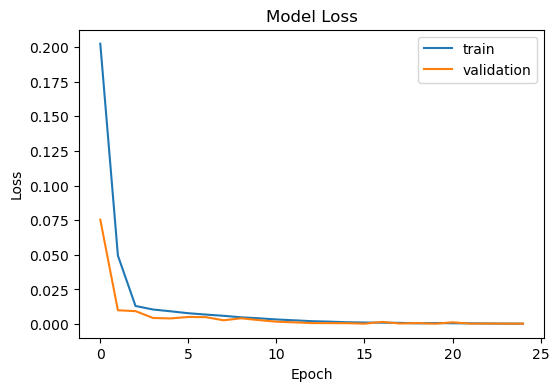

In [33]:
plot_learning_curve(history, metric='loss', title='Model Loss', figsize=(6, 4))

r2:0.79, MSE:0.001893, MAE:0.031052
alanine
r2:0.86, MSE:0.001346, MAE:0.025301
asparagine
r2:0.85, MSE:0.001440, MAE:0.029846
aspartic acid
r2:0.75, MSE:0.002148, MAE:0.032633
glutamic acid
r2:0.74, MSE:0.002859, MAE:0.038070
histidine
r2:0.91, MSE:0.001249, MAE:0.023422
glucosamine
r2:0.67, MSE:0.002315, MAE:0.037037


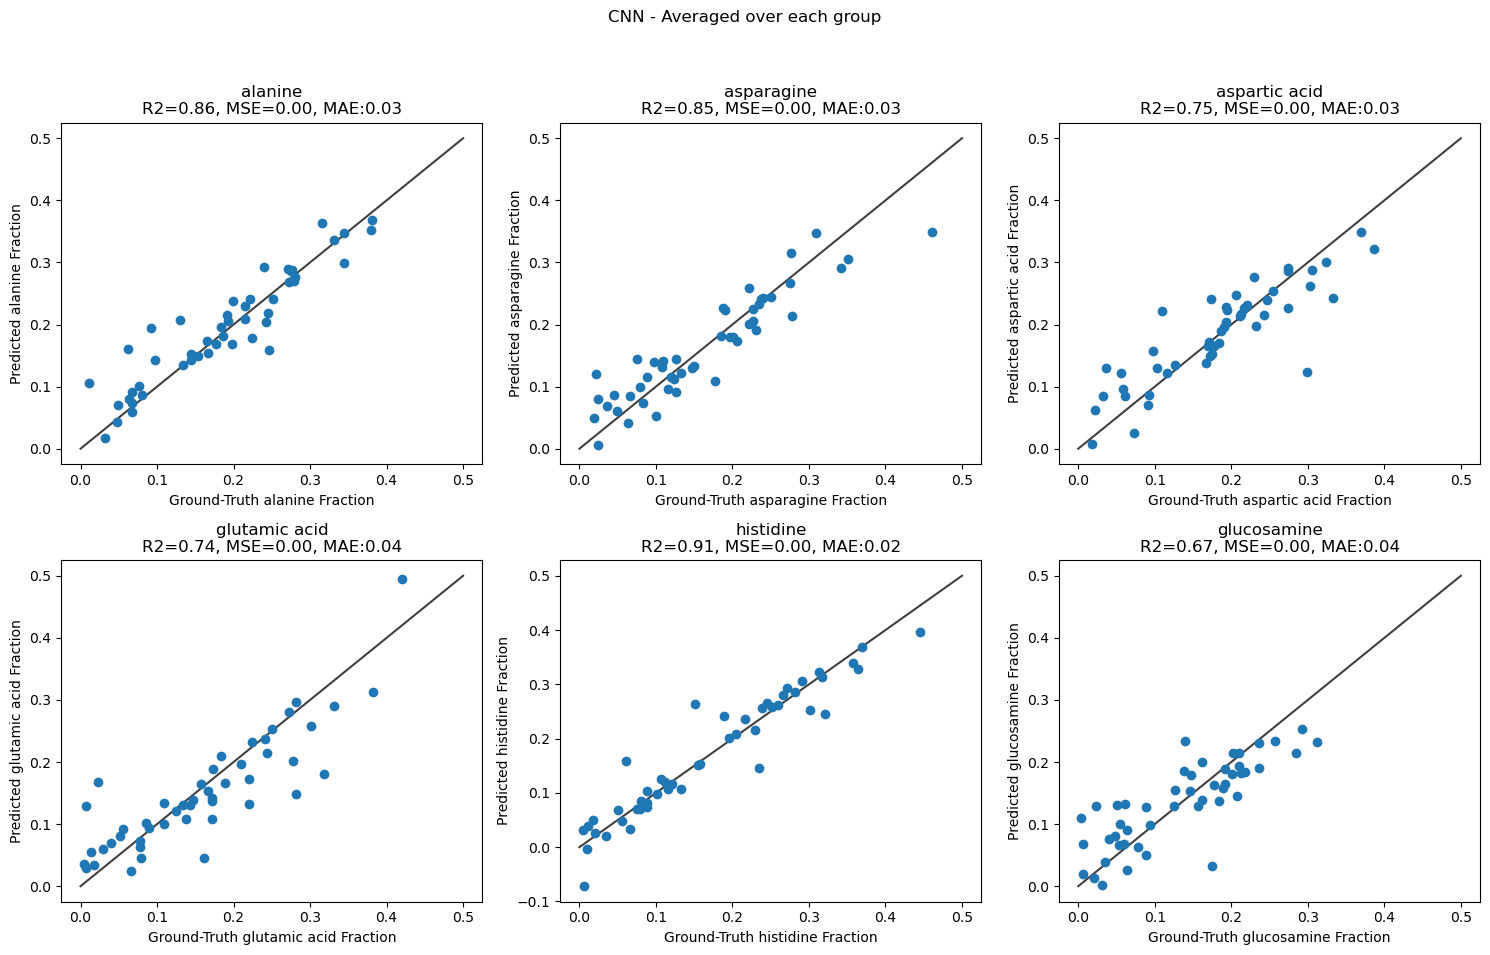

In [34]:
# # Load the arrays from CSV
# y_pred_cv_cnn_m4 = np.loadtxt(os.path.join(saved_predictios_path, 'y_pred_cv_cnn_m4.csv'), delimiter=',')
# y_cv_cnn_m4 = np.loadtxt(os.path.join(saved_predictios_path, 'y_cv_cnn_m4.csv'), delimiter=',')

# For CNN model results
plot_regression_results(y_cv_cnn_m4, y_pred_cv_cnn_m4, y_names, model_type='CNN', title='CNN Model Results')



In [28]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint_no = 'CNN_LOO_8163264128'
# model_name = 'CNN_AUG_0.001_20_16'

# checkpoint_dir = checkpoint_no
# if not os.path.exists(checkpoint_dir):
#     os.makedirs(checkpoint_dir)

# keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir, 
#                                    monitor='val_loss', save_best_only=True, mode='auto'),
#                    EarlyStopping(monitor='val_loss', patience=5, mode='auto', 
#                                  min_delta = 0, verbose=1)]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
y_pred_cv_cnn_m4 = []
y_cv_cnn_m4 = []
# specss_m4 = np.vstack([np.mean(specss[names==name, :], axis=0) for name in np.unique(names)])
# y_m4 = np.vstack([np.mean(y[names==name, :], axis=0) for name in np.unique(names)])

for idx_train, idx_test in LeaveOneOut().split(specss_m4, y_m4, np.unique(names)):
# for idx_train, idx_test in GroupKFold(n_splits=16).split(specss_m4, y_m4, range(len(y_m4))):
    model = cnn_AAM({'compile': True, 'opt': Adam(learning_rate= 0.001)})
    history = model.fit(np.expand_dims(specss_m4[idx_train, :], 2), y_m4[idx_train], epochs=50, batch_size=8,  validation_data=(np.expand_dims(specss_m4[idx_test], 2), y_m4[idx_test]), callbacks=[es])
    y_pred_cv_cnn_m4.append(model.predict(np.expand_dims(specss_m4[idx_test], 2)))
    y_cv_cnn_m4.append(y_m4[idx_test])

y_cv_cnn_m4, y_pred_cv_cnn_m4 = np.vstack(y_cv_cnn_m4), np.vstack(y_pred_cv_cnn_m4)


2023-01-25 14:09:31.601863: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-25 14:09:31.602024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1022, 8)           32        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 511, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 509, 16)           400       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 254, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 252, 32)           1568      
                                                                 
 max_pooling1d_2 (MaxP

2023-01-25 14:09:31.989767: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-25 14:09:32.246980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 85ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 3/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0145 - mse: 0.0145

2023-01-25 14:09:32.951557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 14ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 10/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0

2023-01-25 14:09:34.853622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:09:35.221288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 69ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 2/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 3/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0069 - mse: 0.0069

2023-01-25 14:09:35.737528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 14ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 10/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0

2023-01-25 14:09:38.315511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:09:38.692307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 71ms/step - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 0.0190 - mse: 0.0190

2023-01-25 14:09:39.191270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 18ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.00

2023-01-25 14:09:42.206845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:09:42.582080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 66ms/step - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0059 - val_mse: 0.0059


2023-01-25 14:09:43.072750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 10/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0048 - mse: 0.0048 - va

2023-01-25 14:09:45.375856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:09:45.769346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 81ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.0150 - mse: 0.0150

2023-01-25 14:09:46.352715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 17ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 8.0895e-04 - val_mse: 8.0895e-04
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0041 - mse: 0.0041 - val_lo

2023-01-25 14:09:47.628291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:09:48.027058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 86ms/step - loss: 0.0414 - mse: 0.0414 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 0.0175 - mse: 0.0175

2023-01-25 14:09:48.656128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 21ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 3/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 9/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.00

Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:09:51.932256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:09:52.333640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 82ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0128 - mse: 0.0128

2023-01-25 14:09:52.957948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 20ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 5/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 9/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.00

2023-01-25 14:09:55.784365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:09:56.638265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 101ms/step - loss: 0.0643 - mse: 0.0643 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0463 - mse: 0.0463

2023-01-25 14:09:57.521767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 26ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 4/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.00

2023-01-25 14:10:00.765129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:10:01.148522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 86ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0240 - val_mse: 0.0240
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0261 - mse: 0.0261

2023-01-25 14:10:01.798014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 32ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 5/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 6/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 9/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.00

                                                                 
 conv1d_49 (Conv1D)          (None, 60, 128)           24704     
                                                                 
 max_pooling1d_49 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 30, 128)           0         
                                                                 
 flatten_9 (Flatten)         (None, 3840)              0         
                                                                 
 dense_18 (Dense)            (None, 64)                245824    
                                                                 
 dense_19 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
____

2023-01-25 14:10:05.864908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:10:06.235140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 88ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.0135 - mse: 0.0135

2023-01-25 14:10:06.956120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 19ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 3/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.00

 max_pooling1d_53 (MaxPoolin  (None, 62, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_54 (Conv1D)          (None, 60, 128)           24704     
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_10 (Flatten)        (None, 3840)              0         
                                                                 
 dense_20 (Dense)            (None, 64)                245824    
                                                                 
 dense_21 (Dense)            (None, 6)                 390       
          

2023-01-25 14:10:10.870141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:10:11.259170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 83ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 0.0172 - mse: 0.0172

2023-01-25 14:10:11.885265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 19ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0171 - val_mse: 0.0171
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 6/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 7/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 9/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.01

2023-01-25 14:10:13.608595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:10:14.017954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 98ms/step - loss: 0.1386 - mse: 0.1386 - val_loss: 0.1002 - val_mse: 0.1002
Epoch 2/50
2/6 [=========>....................] - ETA: 0s - loss: 0.0463 - mse: 0.0463

2023-01-25 14:10:14.716069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 31ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 9/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.01

                                                                 
 max_pooling1d_64 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_12 (Flatten)        (None, 3840)              0         
                                                                 
 dense_24 (Dense)            (None, 64)                245824    
                                                                 
 dense_25 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:10:18.682681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:10:19.091901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 117ms/step - loss: 0.0719 - mse: 0.0719 - val_loss: 0.0662 - val_mse: 0.0662
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0577 - mse: 0.0577

2023-01-25 14:10:19.910255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 25ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 3/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 4/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0171 - val_mse: 0.0171
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 7/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 8/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 9/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.01

 conv1d_69 (Conv1D)          (None, 60, 128)           24704     
                                                                 
 max_pooling1d_69 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_13 (Flatten)        (None, 3840)              0         
                                                                 
 dense_26 (Dense)            (None, 64)                245824    
                                                                 
 dense_27 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________


2023-01-25 14:10:24.215408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:10:24.650592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 98ms/step - loss: 0.0988 - mse: 0.0988 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0398 - mse: 0.0398

2023-01-25 14:10:25.403262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 31ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 4/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 6/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.00

2023-01-25 14:10:28.546851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:10:28.959561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 114ms/step - loss: 0.0561 - mse: 0.0561 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0377 - mse: 0.0377

2023-01-25 14:10:29.801518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 34ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 6/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 7/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 9/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.00

                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:10:33.489562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:10:33.895320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 294ms/step - loss: 0.1470 - mse: 0.1470 - val_loss: 0.0634 - val_mse: 0.0634
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0752 - mse: 0.0752

2023-01-25 14:10:35.587840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 39ms/step - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 3/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 9/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.00

Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________


2023-01-25 14:10:39.468818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:10:39.894190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 122ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0149 - mse: 0.0149

2023-01-25 14:10:40.820423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 26ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 3/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 4/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.00

2023-01-25 14:10:43.791492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:10:44.193809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 110ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0393 - mse: 0.0393

2023-01-25 14:10:45.063010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 34ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 9/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.00

2023-01-25 14:10:48.130188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:10:48.542000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 119ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0122 - mse: 0.0122

2023-01-25 14:10:49.404400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 18ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 3/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 4/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 6/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 7/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 8/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 9/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.00

 g1D)                                                            
                                                                 
 conv1d_99 (Conv1D)          (None, 60, 128)           24704     
                                                                 
 max_pooling1d_99 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_19 (Flatten)        (None, 3840)              0         
                                                                 
 dense_38 (Dense)            (None, 64)                245824    
                                                                 
 dense_39 (Dense)            (None, 6)                 390       
                                                                 
Total para

2023-01-25 14:10:53.605720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:10:54.023574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 115ms/step - loss: 0.0988 - mse: 0.0988 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0532 - mse: 0.0532

2023-01-25 14:10:54.859537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 23ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 3/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 6/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 9/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.00

                                                                 
 conv1d_104 (Conv1D)         (None, 60, 128)           24704     
                                                                 
 max_pooling1d_104 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_20 (Flatten)        (None, 3840)              0         
                                                                 
 dense_40 (Dense)            (None, 64)                245824    
                                                                 
 dense_41 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
____

2023-01-25 14:10:59.107409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:10:59.521461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 140ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 2/50


2023-01-25 14:11:00.463799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 28ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 6/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 9/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.00

                                                                 
 max_pooling1d_109 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_21 (Flatten)        (None, 3840)              0         
                                                                 
 dense_42 (Dense)            (None, 64)                245824    
                                                                 
 dense_43 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________


2023-01-25 14:11:04.725782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:11:05.170006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 134ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 2/50
3/6 [==============>...............] - ETA: 0s - loss: 0.0177 - mse: 0.0177

2023-01-25 14:11:06.259576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 34ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 3/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 5/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 6/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.00

2023-01-25 14:11:09.708527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:11:10.155407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 122ms/step - loss: 0.1841 - mse: 0.1841 - val_loss: 0.1128 - val_mse: 0.1128
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.1144 - mse: 0.1144

2023-01-25 14:11:11.036863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 25ms/step - loss: 0.0644 - mse: 0.0644 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 3/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0202 - val_mse: 0.0202
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 8/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.00

2023-01-25 14:11:14.323170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:11:14.769402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 150ms/step - loss: 0.0422 - mse: 0.0422 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 2/50


2023-01-25 14:11:15.714185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 42ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 7/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 8/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 9/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.01

2023-01-25 14:11:19.433528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_120 (Conv1D)         (None, 1022, 8)           32        
                                                                 
 max_pooling1d_120 (MaxPooli  (None, 511, 8)           0         
 ng1D)                                                           
                                                                 
 conv1d_121 (Conv1D)         (None, 509, 16)           400       
                                                                 
 max_pooling1d_121 (MaxPooli  (None, 254, 16)          0         
 ng1D)                                                           
                                                                 
 conv1d_122 (Conv1D)         (None, 252, 32)           1568      
                                                                 
 max_pooling1d_122 (MaxPooli  (None, 126, 32)        

2023-01-25 14:11:21.099910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 140ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0121 - mse: 0.0121

2023-01-25 14:11:22.224632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 29ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 3/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 4/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 7/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 8/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 9/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.00

 conv1d_129 (Conv1D)         (None, 60, 128)           24704     
                                                                 
 max_pooling1d_129 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_25 (Flatten)        (None, 3840)              0         
                                                                 
 dense_50 (Dense)            (None, 64)                245824    
                                                                 
 dense_51 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________


2023-01-25 14:11:26.752757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:11:27.180936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 122ms/step - loss: 0.0323 - mse: 0.0323 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0123 - mse: 0.0123

2023-01-25 14:11:28.177360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 19ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0250 - val_mse: 0.0250
Epoch 3/50
6/6 [==============================] - 0s 58ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0258 - val_mse: 0.0258
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 5/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 6/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 7/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.01

                                                                 
 dropout_26 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_26 (Flatten)        (None, 3840)              0         
                                                                 
 dense_52 (Dense)            (None, 64)                245824    
                                                                 
 dense_53 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:11:32.437760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:11:32.848160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 119ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 2/50


2023-01-25 14:11:33.906426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 48ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 3/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 5/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0202 - val_mse: 0.0202
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0171 - val_mse: 0.0171
Epoch 7/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.01

                                                                 
 max_pooling1d_139 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           


2023-01-25 14:11:38.358222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


                                                                 
 dropout_27 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_27 (Flatten)        (None, 3840)              0         
                                                                 
 dense_54 (Dense)            (None, 64)                245824    
                                                                 
 dense_55 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:11:38.807026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.0265 - mse: 0.0265

2023-01-25 14:11:40.032638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 161ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 2/50
6/6 [==============================] - 0s 38ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 3/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 5/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 6/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0

                                                                 
 dense_56 (Dense)            (None, 64)                245824    
                                                                 
 dense_57 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________


2023-01-25 14:11:43.839336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:11:44.257797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 152ms/step - loss: 0.0672 - mse: 0.0672 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 2/50
2/6 [=========>....................] - ETA: 0s - loss: 0.0297 - mse: 0.0297

2023-01-25 14:11:45.212054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 38ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 3/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 4/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 5/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 6/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 7/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.00

 flatten_29 (Flatten)        (None, 3840)              0         
                                                                 
 dense_58 (Dense)            (None, 64)                245824    
                                                                 
 dense_59 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:11:49.145176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:11:49.556828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 156ms/step - loss: 0.0395 - mse: 0.0395 - val_loss: 0.0250 - val_mse: 0.0250


2023-01-25 14:11:50.585581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50
6/6 [==============================] - 0s 51ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 3/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0053 - mse: 0.0053 - val

2023-01-25 14:11:54.386187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


                                                                 
 flatten_30 (Flatten)        (None, 3840)              0         
                                                                 
 dense_60 (Dense)            (None, 64)                245824    
                                                                 
 dense_61 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:11:54.837546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 140ms/step - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0194 - mse: 0.0194

2023-01-25 14:11:55.994690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 56ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 5/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 6/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 9/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.00

2023-01-25 14:11:59.647669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:12:00.083705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 153ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0151 - mse: 0.0151

2023-01-25 14:12:01.216773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 50ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 3/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 4/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 5/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.00

2023-01-25 14:12:04.085166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:12:05.559925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0196

2023-01-25 14:12:06.741328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 160ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 2/50
6/6 [==============================] - 0s 42ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 3/50
6/6 [==============================] - 0s 40ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 8/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0

2023-01-25 14:12:09.965038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:12:10.408549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 171ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0121 - mse: 0.0121

2023-01-25 14:12:11.588232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 39ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 3/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 4/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 5/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.00

                                                                 
 max_pooling1d_173 (MaxPooli  (None, 62, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_174 (Conv1D)         (None, 60, 128)           24704     
                                                                 
 max_pooling1d_174 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_34 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_34 (Flatten)        (None, 3840)              0         


2023-01-25 14:12:16.293590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


                                                                 
 dense_68 (Dense)            (None, 64)                245824    
                                                                 
 dense_69 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:12:16.758685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 118ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - mse: 0.0188

2023-01-25 14:12:17.796815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 55ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 3/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 4/50
6/6 [==============================] - 0s 42ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 5/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 6/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 9/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.01

 dense_71 (Dense)            (None, 6)                 390       
                                                                 


2023-01-25 14:12:22.018003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:12:22.461404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 164ms/step - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 2/50


2023-01-25 14:12:23.734747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 49ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 3/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 5/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 6/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.00

2023-01-25 14:12:27.405845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:12:27.851588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 160ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 2/50


2023-01-25 14:12:29.040533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 49ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 3/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 8/50
6/6 [==============================] - 0s 43ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 9/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.00

2023-01-25 14:12:32.446325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 ng1D)                                                           
                                                                 
 conv1d_186 (Conv1D)         (None, 509, 16)           400       
                                                                 
 max_pooling1d_186 (MaxPooli  (None, 254, 16)          0         
 ng1D)                                                           
                                                                 
 conv1d_187 (Conv1D)         (None, 252, 32)           1568      
                                                                 
 max_pooling1d_187 (MaxPooli  (None, 126, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_188 (Conv1D)         (None, 124, 64)           6208      
                                                                 
 max_pooling1d_188 (MaxPooli  (None, 62, 64)           0         
 ng1D)    

2023-01-25 14:12:32.893270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.0269 - mse: 0.0269

2023-01-25 14:12:33.871899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 147ms/step - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 2/50
6/6 [==============================] - 0s 47ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 3/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 4/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 5/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 6/50
6/6 [==============================] - 0s 49ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 7/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 8/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0

2023-01-25 14:12:37.803415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_190 (Conv1D)         (None, 1022, 8)           32        
                                                                 
 max_pooling1d_190 (MaxPooli  (None, 511, 8)           0         
 ng1D)                                                           
                                                                 
 conv1d_191 (Conv1D)         (None, 509, 16)           400       
                                                                 
 max_pooling1d_191 (MaxPooli  (None, 254, 16)          0         
 ng1D)                                                           
                                                                 
 conv1d_192 (Conv1D)         (None, 252, 32)           1568      
                                                                 
 max_pooling1d_192 (MaxPooli  (None, 126, 32)        

2023-01-25 14:12:38.282183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 174ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 2/50


2023-01-25 14:12:39.437227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 35ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 3/50
6/6 [==============================] - 0s 45ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 4/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 5/50
6/6 [==============================] - 0s 42ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 6/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 7/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 9/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.00

Epoch 1/50


2023-01-25 14:12:43.220316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-25 14:12:43.620087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.0397 - mse: 0.0397

2023-01-25 14:12:44.897073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 195ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 2/50
6/6 [==============================] - 0s 63ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 3/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 4/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 5/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 6/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 8/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0

2023-01-25 14:12:49.020757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 ng1D)                                                           
                                                                 
 conv1d_203 (Conv1D)         (None, 124, 64)           6208      
                                                                 
 max_pooling1d_203 (MaxPooli  (None, 62, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_204 (Conv1D)         (None, 60, 128)           24704     
                                                                 
 max_pooling1d_204 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_40 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_40 (Flatten)        (None, 3840)              0         
          

2023-01-25 14:12:50.419342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 181ms/step - loss: 0.0405 - mse: 0.0405 - val_loss: 0.0134 - val_mse: 0.0134


2023-01-25 14:12:51.743688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50
6/6 [==============================] - 0s 52ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 3/50
6/6 [==============================] - 0s 49ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 4/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 6/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 7/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 9/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0045 - mse: 0.0045 - val

2023-01-25 14:12:55.640246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:12:56.081699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 195ms/step - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 2/50


2023-01-25 14:12:57.450178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 47ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 4/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 5/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 6/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 8/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.00

2023-01-25 14:13:01.981728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_210 (Conv1D)         (None, 1022, 8)           32        
                                                                 
 max_pooling1d_210 (MaxPooli  (None, 511, 8)           0         
 ng1D)                                                           
                                                                 
 conv1d_211 (Conv1D)         (None, 509, 16)           400       
                                                                 
 max_pooling1d_211 (MaxPooli  (None, 254, 16)          0         
 ng1D)                                                           
                                                                 
 conv1d_212 (Conv1D)         (None, 252, 32)           1568      
                                                                 
 max_pooling1d_212 (MaxPooli  (None, 126, 32)        

2023-01-25 14:13:02.455972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 179ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 2/50


2023-01-25 14:13:03.759528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 26ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 3/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 4/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 5/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 7/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.00

2023-01-25 14:13:06.953342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 dropout_43 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_43 (Flatten)        (None, 3840)              0         
                                                                 
 dense_86 (Dense)            (None, 64)                245824    
                                                                 
 dense_87 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:13:07.398790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 162ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 2/50


2023-01-25 14:13:08.598012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 47ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 4/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 6/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 8/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 9/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.00

2023-01-25 14:13:11.761929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 conv1d_224 (Conv1D)         (None, 60, 128)           24704     
                                                                 
 max_pooling1d_224 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_44 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_44 (Flatten)        (None, 3840)              0         
                                                                 
 dense_88 (Dense)            (None, 64)                245824    
                                                                 
 dense_89 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoc

2023-01-25 14:13:12.217364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.0238 - mse: 0.0238

2023-01-25 14:13:13.481477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 176ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0192 - val_mse: 0.0192
Epoch 2/50
6/6 [==============================] - 0s 60ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 3/50
6/6 [==============================] - 0s 47ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 4/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 8/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0

 dense_91 (Dense)            (None, 6)                 390       
                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________


2023-01-25 14:13:17.530582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:13:17.972665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 184ms/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 2/50


2023-01-25 14:13:19.313931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 51ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 4/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 6/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 7/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.00

2023-01-25 14:13:23.158766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2023-01-25 14:13:23.591976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 157ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0120 - mse: 0.0120

2023-01-25 14:13:24.788444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 35ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 3/50
6/6 [==============================] - 0s 48ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 4/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 5/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 6/50
6/6 [==============================] - 0s 39ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 7/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.00

 max_pooling1d_238 (MaxPooli  (None, 62, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_239 (Conv1D)         (None, 60, 128)           24704     
                                                                 
 max_pooling1d_239 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_47 (Dropout)        (None, 30, 128)           0         
                                                                 
 flatten_47 (Flatten)        (None, 3840)              0         
                                                                 
 dense_94 (Dense)            (None, 64)                245824    
                                                                 
 dense_95 (Dense)            (None, 6)                 390       


2023-01-25 14:13:29.164794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


                                                                 
Total params: 279,126
Trainable params: 279,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-01-25 14:13:29.605392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 155ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0126 - mse: 0.0126

2023-01-25 14:13:30.771856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 46ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 3/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 4/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 5/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 9/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.00

2023-01-25 14:13:34.143624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


/var/folders/mq/3p4k07dn1v3_51y7pn8lvgph0000gn/T/ipykernel_70800/3087721585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

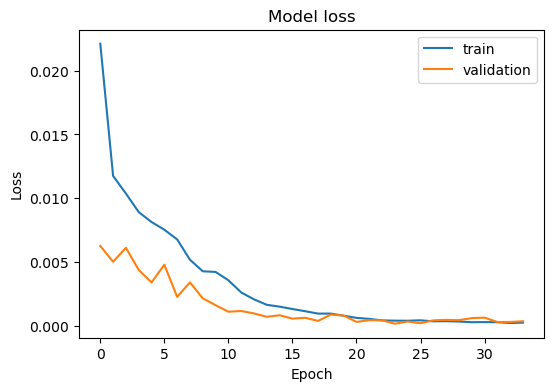

In [29]:
df_loss_mse = pd.DataFrame(history.history)
df_loss= df_loss_mse[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
# df_mse= df_loss_acc[['mse','val_mse']]
# df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
# df_mse.plot(title='Model MSE',figsize=(6,4)).set(xlabel='Epoch',ylabel='MSE')

r2:0.91, MSE:0.000858, MAE:0.021968
alanine
r2:0.90, MSE:0.000929, MAE:0.020620
asparagine
r2:0.89, MSE:0.001048, MAE:0.025945
aspartic acid
r2:0.93, MSE:0.000554, MAE:0.017721
glutamic acid
r2:0.90, MSE:0.001097, MAE:0.025511
histidine
r2:0.96, MSE:0.000487, MAE:0.017218
glucosamine
r2:0.85, MSE:0.001033, MAE:0.024796


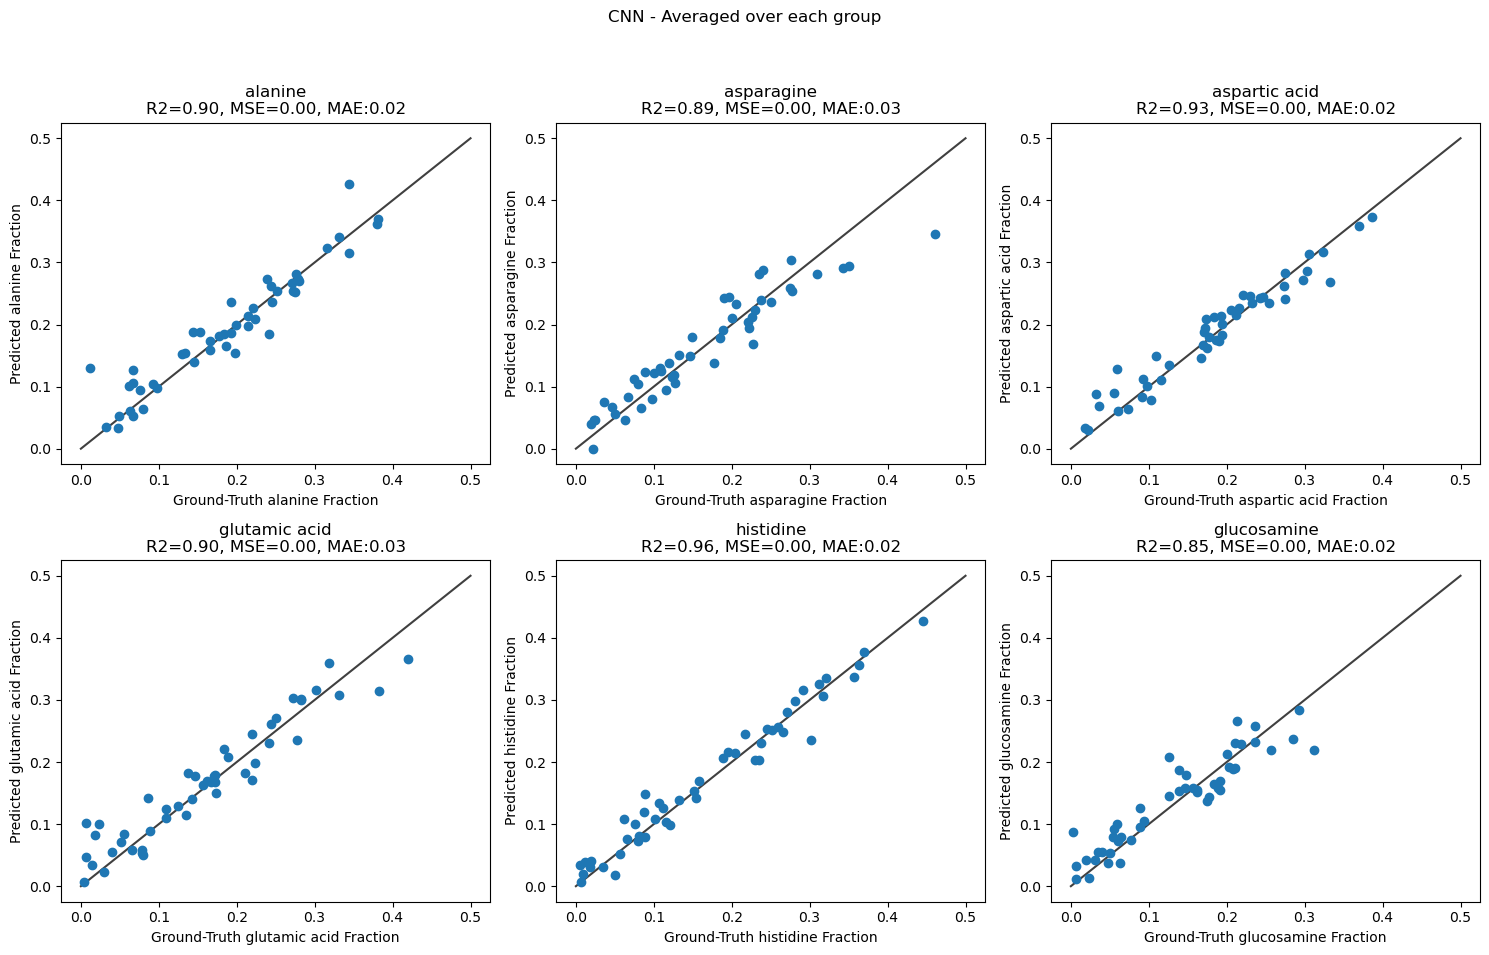

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for idx, ax in enumerate(axs.flatten()):
    ax.scatter(y_cv_cnn_m4[:, idx], y_pred_cv_cnn_m4[:, idx])
    lims = [0, 0.5,]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_xlabel(f'Ground-Truth {y_names[idx]} Fraction')
    ax.set_ylabel(f'Predicted {y_names[idx]} Fraction')
    ax.set_title(f"{y_names[idx]}\nR2={r2_score(y_cv_cnn_m4[:, idx], y_pred_cv_cnn_m4[:, idx]):.2f}, MSE={mean_squared_error(y_cv_cnn_m4[:, idx], y_pred_cv_cnn_m4[:, idx]):.2f}, MAE:{mean_absolute_error(y_cv_cnn_m4[:, idx], y_pred_cv_cnn_m4[:, idx]):.2f}")
plt.suptitle(f"CNN - Averaged over each group")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print(f'r2:{r2_score(y_cv_cnn_m4, y_pred_cv_cnn_m4):.2f}, MSE:{mean_squared_error(y_cv_cnn_m4, y_pred_cv_cnn_m4):.6f}, MAE:{mean_absolute_error(y_cv_cnn_m4, y_pred_cv_cnn_m4):.6f}')
for idx in range(6):
    print(y_names[idx])
    print(f'r2:{r2_score(y_cv_cnn_m4[:, idx], y_pred_cv_cnn_m4[:, idx]):.2f}, MSE:{mean_squared_error(y_cv_cnn_m4[:, idx], y_pred_cv_cnn_m4[:, idx]):.6f}, MAE:{mean_absolute_error(y_cv_cnn_m4[:, idx], y_pred_cv_cnn_m4[:, idx]):.6f}')
#plt.savefig(os.path.join(os.path.join(os.getcwd(), 'figs'), "cnn_hand_mixed.png") , dpi=800) 